

# Project: Investigate the Soccer Database Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> In this report we will focus on the top 4 European leagues data taken from the Soccer Database (England, Spain, Germany and Italy).
   And we will try to explore the data available about the teams from 2008 to 2015
  in order to come out with answers to the following questions:<br>
> <br> **Questions**<br>

>   From the top 4 leagues in question, which teams are the most successful? <br>
>   What are the technical characteristics of successfull/winning teams compared
    to the other teams?<br> 
>  1.away win vs home win , Goal scored vs Goal conceded  <br>
>  2.In general do successful/winning teams have more Ball possession? <br>
>  3.Do they have more shot on targets? <br>

>Which English premier league teams have most improved between 2012 and 2014? 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.cElementTree as ET
import sqlite3
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties 
> First of all the Data is organized in sqlite database tables
> What we are intersted in is get all the matches information related
> to  4 countries England, Spain, Germany and Italy.
> Also we will load the Team_Attributes table
> Before loading the data let's check the important tables.


In [2]:
conn = sqlite3.connect('database.sqlite')

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)

tables





,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...



### Data Cleaning (Replace this with more specific notes!)
> We will use SQL Join to Join Match table to Country table on country_id and Team table 
 on team_api_id in order to get the match related country, Home team name and Away team name 
> 

In [28]:
#list of countries are found in Country table

countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [29]:
#list of teams are found in Team table
teams = pd.read_sql("""SELECT *
                        FROM Team limit 5;""", conn)
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673,KRC Genk,GEN
1,2,9993,675,Beerschot AC,BAC
2,3,10000,15005,SV Zulte-Waregem,ZUL
3,4,9994,2007,Sporting Lokeren,LOK
4,5,9984,1750,KSV Cercle Brugge,CEB


In [30]:
#List of matches
matches = pd.read_sql("""SELECT *
                        FROM Match limit 3;""", conn)
matches

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75


> There is quite a lot of columns, but we are only interested in:<br>
> country, date, home_team name, away_team name
> home_team_api_id
> away_team_api_id
> home_team goal away_team goal
> goal, shoton, possession

In [5]:
df_4leagues = pd.read_sql("""SELECT Match.id AS match_id, 
                               Country.name AS country, 
                               season, stage, date, 
                               hteam.team_long_name AS home_team,
                               ateam.team_long_name AS away_team, 
                               home_team_api_id AS home_team_id,
                               away_team_api_id as away_team_id, 
                               home_team_goal, away_team_goal, 
                               goal, shoton, possession                                     
                               FROM Match
                               JOIN Country on Country.id = Match.country_id
                               AND Country.name in ('England', 'Germany', 'Italy', 'Spain')
                               JOIN Team AS hteam on hteam.team_api_id = Match.home_team_api_id
                               JOIN Team AS ateam on ateam.team_api_id = Match.away_team_api_id""", conn)

df_4leagues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11545 entries, 0 to 11544
Data columns (total 14 columns):
match_id          11545 non-null int64
country           11545 non-null object
season            11545 non-null object
stage             11545 non-null int64
date              11545 non-null object
home_team         11545 non-null object
away_team         11545 non-null object
home_team_id      11545 non-null int64
away_team_id      11545 non-null int64
home_team_goal    11545 non-null int64
away_team_goal    11545 non-null int64
goal              11541 non-null object
shoton            11541 non-null object
possession        11541 non-null object
dtypes: int64(6), object(8)
memory usage: 902.0+ KB


> let's load the Team_Attributes table data.<br>
> The Team_Attributes table contains the team_api_id but not the team name. <br>
> We will Join Team_Attrbiutes table with Team table on team_api_id. <br>


In [6]:
df_team_attr = pd.read_sql("""SELECT Team.team_long_name, Team_Attributes.* 
                                FROM Team
                                JOIN Team_Attributes
                                ON Team.team_api_id = Team_Attributes.team_api_id """, conn)

                               

In [7]:
#check for duplicated values in df_4leagues
sum(df_4leagues.duplicated())

0

In [8]:
# we have 3 columns with Null Values goal, shoton and possession
sum(df_4leagues.isnull().any())

3

In [9]:
# modifying date to datetime datatype
df_4leagues['date'] = pd.to_datetime(df_4leagues['date'], format='%Y-%m-%d')

In [10]:
# let's change the format to take the first year of the season
# easier to work with instead of 2008/2009 --> 2008
df_4leagues['season']=df_4leagues['season'].apply(lambda x: x.split('/')[0])

> Since each row in the df_4leagues DataFrame represents a match <br>
> we have home_team and away_team in each row. <br>
> So each Team can be once a home_team and in the other the away_team depending <br>
> on home leg games and away leg games. <br>
> In order to get the technical attributes by team and above all the Winning percentage <br>
> by team, we will split the data set between home teams and away teams DataFrames <br>
<br>
> In the original DataFrames: goal, shoton and possession columns contain data in XML format
> We need to extract the intersting Data from XML trees

In [11]:
#let's start by goal column in order to extract the penalties scored data
df_4leagues1 = df_4leagues.copy()
# getting the intersting columns 
df_4l_pen = df_4leagues[['match_id', 'country', 'season',
                         'stage', 'date', 'home_team',
                         'away_team', 'goal', 'home_team_id',
                         'away_team_id']]
df_4l_pen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11545 entries, 0 to 11544
Data columns (total 10 columns):
match_id        11545 non-null int64
country         11545 non-null object
season          11545 non-null object
stage           11545 non-null int64
date            11545 non-null datetime64[ns]
home_team       11545 non-null object
away_team       11545 non-null object
goal            11541 non-null object
home_team_id    11545 non-null int64
away_team_id    11545 non-null int64
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 676.5+ KB


In [37]:
sum(df_4l_pen.duplicated())

0

In [12]:
#we can ignore those values for the moment
sum(df_4l_pen['goal'].isnull())

4

> 'get_penalties' function will be used to get the number of penalties per game for each team <br>
> the function will be supplied by a home_team DF and away_team DF at a time to count the penalties <br>
> Once done we will merge the 2 DataFrames together based on match_id to get the data by match. <br>
> The same logic will be used later to get shoton and possession by match for each team<br>
**Note**:<br>
> missing home team penalties and away team penalties will be replaced by zeros <br>



In [13]:
from collections import defaultdict
def get_penalties(df, columnname, xml_elt, home_team=True):
    '''Function takes an original DataFrame,
       column name in this case "goal" and
       "xml_elt" (goal_type), and boolean home_team
       if True we are checking home_team goals
       if false we are checking away_team goals
       used for searching the XML tree 
       in each row of the 'goal' column.
       Returns an new DFrame including the match_id,
       the team_id and the number of penalties scored 
       if no penalties were found returns 0'''
    # initalize list match_ids
    matches = defaultdict(list)
    team = defaultdict(list)
    goal = defaultdict(list)
    # iterate over df rows and output them as tuples
    for row in df[df[columnname].notnull()].itertuples():
        listpenalties = []
        # get match_id position from original DataFrame
        game_id = row[df.columns.get_loc('match_id') + 1]
        if home_team: 
        # get match_id home_team_id from the original DataFrame
            teamid = row[df.columns.get_loc('home_team_id') + 1]
            pen = 'hteam_pen'
        else:
        #get match_id away_team_id from the original DataFrame
            teamid = row[df.columns.get_loc('away_team_id') + 1]
            pen='ateam_pen'

        # get XML tree for each row for column goal 
        tree = ET.ElementTree(ET.fromstring(row[df.columns.get_loc(columnname) + 1]))
        # element 'goal' <Element 'goal' at 0x00F9CCC0>
        root= tree.getroot()
        a = 0
        b = 0
        for event in root.findall('value'):
       
            if event.find('team') is None:
                a=1
            else:
                b=1
                #check that team_id in xml matching DataFrame team_id
                if int(event.find('team').text) == teamid:
                   
                    if event.find(xml_elt).text is None:
                        continue
                    else:
                 #if goal_type element equal to 'p'
                 # means this a penalty goal
                        if event.find(xml_elt).text == 'p':
                            listpenalties.append(1)
         
        if a > 0 or b > 0:
            #populate dicts with data
            goal[pen].append(len(listpenalties))
            matches['match_id'].append(game_id)
            team['club_id'].append(teamid)
        else:
            #if the row contains wrong XML tree tags
            #return none to be handled later
            goal[pen].append(None)
            matches['match_id'].append(game_id)
            team['club_id'].append(teamid)                   
                        
    print(len(matches['match_id']))
    print(len(team['club_id']))
    print (len(goal[pen]))
        
    data = {**matches, **team, **goal}
    return pd.DataFrame(data)

In [14]:
#let's get penalties scored  by home teams
df_pen_hteam=get_penalties(df_4l_pen,'goal', 'goal_type')
df_pen_hteam.info()

11541
11541
11541
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 3 columns):
club_id      11541 non-null int64
hteam_pen    10752 non-null float64
match_id     11541 non-null int64
dtypes: float64(1), int64(2)
memory usage: 270.5 KB


In [15]:
#rename club_id to hteam_id
df_pen_hteam.rename(columns = {'club_id':'hteam_id'} , inplace =True)
df_pen_hteam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 3 columns):
hteam_id     11541 non-null int64
hteam_pen    10752 non-null float64
match_id     11541 non-null int64
dtypes: float64(1), int64(2)
memory usage: 270.5 KB


In [16]:
df_pen_ateam=get_penalties(df_4l_pen,'goal', 'goal_type', home_team =False)
df_pen_ateam.info()

11541
11541
11541
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 3 columns):
ateam_pen    10752 non-null float64
club_id      11541 non-null int64
match_id     11541 non-null int64
dtypes: float64(1), int64(2)
memory usage: 270.5 KB


In [17]:
df_pen_ateam.rename(columns = {'club_id':'ateam_id'}, inplace =True)
df_pen_ateam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 3 columns):
ateam_pen    10752 non-null float64
ateam_id     11541 non-null int64
match_id     11541 non-null int64
dtypes: float64(1), int64(2)
memory usage: 270.5 KB


In [18]:
#let's merge away_team penalties with home_team penalties
#based on match_id to have the data by match
df_apen_hpen = pd.merge(df_pen_hteam, df_pen_ateam, on='match_id', how='outer')
df_apen_hpen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11541 entries, 0 to 11540
Data columns (total 5 columns):
hteam_id     11541 non-null int64
hteam_pen    10752 non-null float64
match_id     11541 non-null int64
ateam_pen    10752 non-null float64
ateam_id     11541 non-null int64
dtypes: float64(2), int64(3)
memory usage: 541.0 KB


In [19]:
#dropping the below columns
df_apen_hpen.drop(['hteam_id', 'ateam_id'], axis=1, inplace = True)


In [20]:
df_apen_hpen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11541 entries, 0 to 11540
Data columns (total 3 columns):
hteam_pen    10752 non-null float64
match_id     11541 non-null int64
ateam_pen    10752 non-null float64
dtypes: float64(2), int64(1)
memory usage: 360.7 KB


In [21]:
#let's merge df_apen_hpen with the orignal dataset
df_4leaguespart = df_4leagues1.drop(['home_team_id', 'away_team_id',
                                    'goal', 'shoton', 'possession'], axis =1)

>Merging the hteam penalties and away team penalties extracted from XML with the original 
Data Set, in order to add these new info to the matches columns already available

In [22]:
dfnew = pd.merge(df_4leaguespart, df_apen_hpen, left_on='match_id', right_on='match_id', how='left')
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11545 entries, 0 to 11544
Data columns (total 11 columns):
match_id          11545 non-null int64
country           11545 non-null object
season            11545 non-null object
stage             11545 non-null int64
date              11545 non-null datetime64[ns]
home_team         11545 non-null object
away_team         11545 non-null object
home_team_goal    11545 non-null int64
away_team_goal    11545 non-null int64
hteam_pen         10752 non-null float64
ateam_pen         10752 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 902.0+ KB


> filling Null hteam_pen and ateam_pen with Zeros

In [23]:
#again let's replace the missing hteam_pen and at_eam
#penalties with Zeros
dfnew.fillna(0, inplace= True)
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11545 entries, 0 to 11544
Data columns (total 11 columns):
match_id          11545 non-null int64
country           11545 non-null object
season            11545 non-null object
stage             11545 non-null int64
date              11545 non-null datetime64[ns]
home_team         11545 non-null object
away_team         11545 non-null object
home_team_goal    11545 non-null int64
away_team_goal    11545 non-null int64
hteam_pen         11545 non-null float64
ateam_pen         11545 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 902.0+ KB


> For **shoton** and **possession**, we will focus on **England matches** ONLY
> since most of the XML trees for the other leagues are not complete, so we might not
get accurate data in this case. <br>
> The last possession with the last_elapsed time found in the XML tree will be taken in order to have the possession recorded of the whole time of the game. <br>
> e.g  for elapsed 45, and elapsed 90. <br>
> we will get the possession for elapsed 90 which means possession recorded 
> after 90 minutes of play since the game kick-off <br>
> let's start by possession column <br>
> **Note**: <br>
> NULL values for home team possession will be replaced with Average home possession. <br>
> While away team possession will be replaced with Average away possession.

In [27]:
# let's filter the original DataFrame with country 'England'
# After checking the Data, possession and shoton
# columns which both contain XML tags, 
# with the leasr NULL values between 2008 to 2015
# for England Premier league
# So we will extract the needed tags from England DataFrame

# filter the data based on Country England
england_epl = df_4leagues[df_4leagues.country == 'England']

england_epl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3039
Data columns (total 14 columns):
match_id          3040 non-null int64
country           3040 non-null object
season            3040 non-null object
stage             3040 non-null int64
date              3040 non-null datetime64[ns]
home_team         3040 non-null object
away_team         3040 non-null object
home_team_id      3040 non-null int64
away_team_id      3040 non-null int64
home_team_goal    3040 non-null int64
away_team_goal    3040 non-null int64
goal              3040 non-null object
shoton            3040 non-null object
possession        3040 non-null object
dtypes: datetime64[ns](1), int64(6), object(7)
memory usage: 273.1+ KB


In [28]:
sum(england_epl.duplicated())

0

In [29]:
#will be used later in the merge with possession DataFrame obtained
eplcopy = england_epl.loc[:, ['match_id','country','season','stage','date',
                            'home_team','away_team', 'home_team_goal', 'away_team_goal' ]]
eplcopy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3039
Data columns (total 9 columns):
match_id          3040 non-null int64
country           3040 non-null object
season            3040 non-null object
stage             3040 non-null int64
date              3040 non-null datetime64[ns]
home_team         3040 non-null object
away_team         3040 non-null object
home_team_goal    3040 non-null int64
away_team_goal    3040 non-null int64
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 190.0+ KB


>Function takes an original DataFrame, columnname in this case 'possession' and
'xml_elt' (awaypos or homepos) used for searching the XML tree in each row of the 'possession' column.<br>
> Returns an new DFrame including the match_id, and the possession percentage. The last possession with the last_elapsed time found in the XML tree is taken in order to have the possession recorded of the whole time of the game.

In [30]:
###get Possession ###
##we will apply this only for EPL data
from collections import defaultdict
def get_possession(df, columnname, xml_elt):
    '''Function takes an original DataFrame,
       columnname in this case 'possession' and
       'xml_elt' (awaypos or homepos) 
       used for searching the XML tree 
       in each row of the 'possession' column.
       Returns an new DFrame including the match_id,
       and the possession percentage.
       The last possession with the last_elapsed time found 
       in the XML tree is taken in order to have the possession 
       recorded of the whole time of the game.
       e.g  for <elapsed>45</elapsed>, <elapsed>90</elapsed>
       we get the possession for elapsed 90 which means 
       possession recorded after 90 minutes of play'''
    
    # initalize defaut dict match_id
    matches = defaultdict(list)
    #initialize default dict possession
    possession = defaultdict(list)
    # iterate over df rows and output them as tuples
    for row in df[df[columnname].notnull()].itertuples():
        listposs = []
        # get match_id position from original DataFrame
        game_id = row[df.columns.get_loc('match_id') + 1]
        if xml_elt == 'homepos': 
            # get home_team_id position from original DataFrame
            teamid = row[df.columns.get_loc('home_team_id') + 1]
            poss = 'hteam_poss'
            
        else:
            # get home_team_id position from original DataFrame
            teamid = row[df.columns.get_loc('away_team_id') + 1]
            poss = 'ateam_poss'
        # get tree for each xml row for column : possession
        tree = ET.ElementTree(ET.fromstring(row[df.columns.get_loc(columnname) + 1]))
        root= tree.getroot()
        
        # getting all 'value' elements in child 
        for event in root.findall('value'):
            if event.find(xml_elt) is None:
                pass
            else:
                #if elapsed time found
                if (event.find('elapsed').text):
                # check awaypos or homepos 
                    if event.find(xml_elt).text is None:
                        pass
                    else:
                        listposs.append(event.find(xml_elt).text)
        if len(listposs) > 0:
            #get last possession appended to the list
            possession[poss].append(int(listposs[-1]))
            matches['match_id'].append(game_id)
        else:
            #if no possession was found append None
            possession[poss].append(None)
            matches['match_id'].append(game_id)
            

            
      
    print(len(possession[poss]))
    print(len(matches['match_id']))
    data = {**matches, **possession}
    return pd.DataFrame(data)

In [31]:
# extracting home team and away team possession
# for EPL
df_aposs = get_possession(england_epl,'possession', 'awaypos')
df_hposs = get_possession(england_epl,'possession', 'homepos')

3040
3040
3040
3040


In [34]:
#merging df_aposs (output of get_possession) and df_hposs (output of get_possession) 
#since we need all data from both data frame we are using outer join
df_aposs_hposs = pd.merge(df_aposs, df_hposs, on='match_id', how='outer') 

> merge orginial DataFrame with df containing home and away possession
for each match_id

In [35]:
#merge orginial DataFrame with df containing home and away possession
# for each match_id
epl_poss = pd.merge(eplcopy, df_aposs_hposs, left_on='match_id', right_on='match_id', how='outer') 
epl_poss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3039
Data columns (total 11 columns):
match_id          3040 non-null int64
country           3040 non-null object
season            3040 non-null object
stage             3040 non-null int64
date              3040 non-null datetime64[ns]
home_team         3040 non-null object
away_team         3040 non-null object
home_team_goal    3040 non-null int64
away_team_goal    3040 non-null int64
ateam_poss        3035 non-null float64
hteam_poss        3035 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 237.5+ KB


> fill Null values with average of Home possession for hteam_pos
> fill Null values with average of Away possession for ateam_pos

In [36]:
#we will fill Null values with average of Home possession
#this for missing home possession values
epl_poss.hteam_poss.fillna(epl_poss.hteam_poss.mean(), inplace =True)

In [37]:
#we will fill Null values with average of away possession
#this for missing away possession values
epl_poss.ateam_poss.fillna(epl_poss.ateam_poss.mean(), inplace =True)

In [38]:
epl_poss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3039
Data columns (total 11 columns):
match_id          3040 non-null int64
country           3040 non-null object
season            3040 non-null object
stage             3040 non-null int64
date              3040 non-null datetime64[ns]
home_team         3040 non-null object
away_team         3040 non-null object
home_team_goal    3040 non-null int64
away_team_goal    3040 non-null int64
ateam_poss        3040 non-null float64
hteam_poss        3040 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 237.5+ KB


In [39]:
sum(epl_poss.duplicated())

0

> let's get shoton number for home team and away team

In [40]:
def shotsont(df,columnname,xml_elt, home_team=True):
    '''Function takes an original DataFrame,
       columnname in this case 'possession and
       'xml_elt' (type), and boolean home_team
       if True we are checking home_team shoton
       if false we are checking away_team shoton
       used for searching the XML tree 
       in each row of the 'shoton' column.
       Returns an new DFrame including the match_id,
       the team_id and number of  shotontarget per game
       If no Shot on target found it returns 0 as
       number of shot on target'''

    # initalize defaultdicts
    matches = defaultdict(list)
    team = defaultdict(list)
    goal = defaultdict(list)
    shots = defaultdict(list)
    # iterate over df rows and output them as tuples
    for row in df[df[columnname].notnull()].itertuples():
        listshots = []
        # get match_id position from original DataFrame
        game_id = row[df.columns.get_loc('match_id') + 1]
        if home_team: 
            # get home_team_id position from original DataFrame
            teamid = row[df.columns.get_loc('home_team_id') + 1]
            shoton = 'hteam_shoton'

        else:
            # get away_team_id position from original DataFrame
            teamid = row[df.columns.get_loc('away_team_id') + 1]
            shoton ='ateam_shoton'

        # get tree for each xml row for column shoton
        tree = ET.ElementTree(ET.fromstring(row[df.columns.get_loc(columnname) + 1]))
        root= tree.getroot()
        a = 0
        b = 0
        for event in root.findall('value'):
       
            if event.find('team') is None:
                a=1
                
            else:
                b=1
                if int(event.find('team').text) == teamid:
                   
                    if event.find(xml_elt).text is None:
                        continue
                    else:
                     
                        if event.find(xml_elt).text == 'shoton':
                            listshots.append(1)
         
        if a > 0 or b > 0:
            shots[shoton].append(len(listshots))
            matches['match_id'].append(game_id)
            team['club_id'].append(teamid)
        else:
            shots[shoton].append(None)
            matches['match_id'].append(game_id)
            team['club_id'].append(teamid)                   
                        
    print(len(matches['match_id']))
    print(len(team['club_id']))
    print (len(shots[shoton]))
        
    data = {**matches, **team, **shots}
    return pd.DataFrame(data)

In [41]:
df_hshoton = shotsont(england_epl,'shoton', 'type')
df_ashoton = shotsont(england_epl,'shoton', 'type', home_team = False)

3040
3040
3040
3040
3040
3040


In [42]:
#merging away shoton with home shoton based on match_id
df_ashot_hshot = pd.merge(df_ashoton, df_hshoton, on='match_id', how='outer') 
df_ashot_hshot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3039
Data columns (total 5 columns):
ateam_shoton    3040 non-null int64
club_id_x       3040 non-null int64
match_id        3040 non-null int64
club_id_y       3040 non-null int64
hteam_shoton    3040 non-null int64
dtypes: int64(5)
memory usage: 142.5 KB


In [43]:
# Now merge away_home_shoton with the original dataframe based on matchid
epl_shoton = pd.merge(eplcopy, df_ashot_hshot, left_on='match_id', right_on='match_id', how='outer') 
epl_shoton.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3039
Data columns (total 13 columns):
match_id          3040 non-null int64
country           3040 non-null object
season            3040 non-null object
stage             3040 non-null int64
date              3040 non-null datetime64[ns]
home_team         3040 non-null object
away_team         3040 non-null object
home_team_goal    3040 non-null int64
away_team_goal    3040 non-null int64
ateam_shoton      3040 non-null int64
club_id_x         3040 non-null int64
club_id_y         3040 non-null int64
hteam_shoton      3040 non-null int64
dtypes: datetime64[ns](1), int64(8), object(4)
memory usage: 285.0+ KB


> We will merge the XML data extracted from the original shoton and possession columns <br>
> in order to obtain a home team DF and away team DF with new shoton and possession columns
> in the proper format to perform Data Exploration <br>


In [44]:
# Now let's merge Shoton and Possession DataFrames together
epl_poss2 = epl_poss.copy()
#merge shoton goal with the possession
epl_poss_shots = pd.merge(epl_poss2 , df_ashot_hshot, on='match_id', how='outer')

In [45]:
epl_poss_shots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3039
Data columns (total 15 columns):
match_id          3040 non-null int64
country           3040 non-null object
season            3040 non-null object
stage             3040 non-null int64
date              3040 non-null datetime64[ns]
home_team         3040 non-null object
away_team         3040 non-null object
home_team_goal    3040 non-null int64
away_team_goal    3040 non-null int64
ateam_poss        3040 non-null float64
hteam_poss        3040 non-null float64
ateam_shoton      3040 non-null int64
club_id_x         3040 non-null int64
club_id_y         3040 non-null int64
hteam_shoton      3040 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(8), object(4)
memory usage: 332.5+ KB


>get only important columns and rename home and away columns to more general e.g hteam_poss and ateam_poss to possession ateam_shoton and hteam_shoton to shoton england_hteam and england_ateam will be used later for exploration and visualization

In [46]:
#get only important columns and rename home and away columns
# to more general e.g hteam_poss and ateam_poss to possession
# ateam_shoton and hteam_shoton to shoton
# england_hteam and england_ateam will be used later
# for exploration and visualization
england_hteam = epl_poss_shots.loc[ : , ['match_id', 'country', 'season', 
                          'date', 'home_team', 'home_team_goal', 
                      'away_team_goal', 'hteam_poss' ,'hteam_shoton']]

england_hteam.rename(columns={'home_team' : 'team', 'home_team_goal' : 'goal_for', 
                            'away_team_goal': 'goal_against', 'hteam_poss' : 'possession', 'hteam_shoton': 'shoton' } 
                   , inplace = True)

england_ateam = epl_poss_shots.loc[ : , ['match_id', 'country', 'season', 
                         'date', 'away_team', 'home_team_goal', 
                          'away_team_goal', 'ateam_poss', 'ateam_shoton']]

england_ateam.rename(columns={'away_team' : 'team', 'away_team_goal': 'goal_for', 
                            'home_team_goal': 'goal_against', 'ateam_poss': 'possession', 'ateam_shoton': 'shoton' } 
                , inplace = True)


In [47]:
england_ateam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3039
Data columns (total 9 columns):
match_id        3040 non-null int64
country         3040 non-null object
season          3040 non-null object
date            3040 non-null datetime64[ns]
team            3040 non-null object
goal_against    3040 non-null int64
goal_for        3040 non-null int64
possession      3040 non-null float64
shoton          3040 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 201.9+ KB


In [48]:
england_ateam.head()

,match_id,country,season,date,team,goal_against,goal_for,possession,shoton
0,1729,England,2008,2008-08-17,Newcastle United,1,1,45.0,1
1,1730,England,2008,2008-08-16,West Bromwich Albion,1,0,34.0,2
2,1731,England,2008,2008-08-16,Liverpool,0,1,54.0,11
3,1732,England,2008,2008-08-16,Wigan Athletic,2,1,48.0,7
4,1733,England,2008,2008-08-17,Manchester City,4,2,48.0,9


In [49]:
england_hteam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3039
Data columns (total 9 columns):
match_id        3040 non-null int64
country         3040 non-null object
season          3040 non-null object
date            3040 non-null datetime64[ns]
team            3040 non-null object
goal_for        3040 non-null int64
goal_against    3040 non-null int64
possession      3040 non-null float64
shoton          3040 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 201.9+ KB


In [50]:
england_hteam.head()

,match_id,country,season,date,team,goal_for,goal_against,possession,shoton
0,1729,England,2008,2008-08-17,Manchester United,1,1,55.0,11
1,1730,England,2008,2008-08-16,Arsenal,1,0,66.0,12
2,1731,England,2008,2008-08-16,Sunderland,0,1,46.0,4
3,1732,England,2008,2008-08-16,West Ham United,2,1,52.0,5
4,1733,England,2008,2008-08-17,Aston Villa,4,2,52.0,5


> get only important columns and rename home and away columns ateam_pen and hteam_scored to pen_scored
> df_home_hteam and df_home_ateam will be used later for exploration and visualization

In [51]:
#get only important columns and rename home and away columns
#  like ateam_pen and hteam_scored to pen_scored
# home_hteam and home_ateam will be used later
# for exploration and visualization

dfnew[['ateam_pen', 'hteam_pen']] = dfnew[['ateam_pen', 'hteam_pen']].astype(int)


df_hometeam = dfnew.loc[ : , ['match_id', 'country', 'season', 
                          'date', 'home_team', 'home_team_goal', 
                      'away_team_goal', 'hteam_pen']]

df_hometeam.rename(columns={'home_team' : 'team', 'home_team_goal' : 'goal_for', 
                            'away_team_goal': 'goal_against', 'hteam_pen': 'pen_scored'} 
                   , inplace = True)

df_awayteam = dfnew.loc[ : , ['match_id', 'country', 'season', 
                         'date', 'away_team', 'home_team_goal', 
                          'away_team_goal', 'ateam_pen' ]]

df_awayteam.rename(columns={'away_team' : 'team', 'away_team_goal': 'goal_for', 
                            'home_team_goal': 'goal_against', 'ateam_pen' : 'pen_scored'} 
                , inplace = True)


In [52]:
df_hometeam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11545 entries, 0 to 11544
Data columns (total 8 columns):
match_id        11545 non-null int64
country         11545 non-null object
season          11545 non-null object
date            11545 non-null datetime64[ns]
team            11545 non-null object
goal_for        11545 non-null int64
goal_against    11545 non-null int64
pen_scored      11545 non-null int32
dtypes: datetime64[ns](1), int32(1), int64(3), object(3)
memory usage: 631.4+ KB


In [53]:
df_awayteam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11545 entries, 0 to 11544
Data columns (total 8 columns):
match_id        11545 non-null int64
country         11545 non-null object
season          11545 non-null object
date            11545 non-null datetime64[ns]
team            11545 non-null object
goal_against    11545 non-null int64
goal_for        11545 non-null int64
pen_scored      11545 non-null int32
dtypes: datetime64[ns](1), int32(1), int64(3), object(3)
memory usage: 631.4+ KB


<a id='eda'></a>
## Exploratory Data Analysis

> Below are the Functions used to get a new DataFrame with each row representing
> data for one team grouped by season, which is the combination of home_team and away_team
  DataFrames. 
> the new DataFrame will include stats:
> 
       1. win percentage
       2. Percentage of home Wins from the total games played at home
       3. Percentage of Away wins from the total games played away 
       4. Average goal scored by game
       5. Average goal conceded by game
       6. Average Penalties scored by game
       
>       if country England is provided:
       1. Average possession
       2. Average shoton
       3. Ratio of goals to shots on target

In [168]:

def get_match_result(teamA_goals, teamB_goals):
    '''Function that gets both home_team goal 
     and away_team goal as input
     depending on the DataFrame 
     Home_team DF or Away_team DF
     compare them to get the match results
     Called to create a new column called result
     in the DataFrame'''
    
    if teamA_goals == teamB_goals:
        return 'D'
    elif teamA_goals > teamB_goals:
        return 'W'
    else:
        return 'L'

def dataset_by_country_season(dframe,country=None,season=None):
    ''' function To automatically filter dataframe
      by season or country or both combined'''
    if (season and country):
        df_new = dframe.loc[(dframe.country== country) & (dframe.season == season)]
    elif (country):
        df_new = dframe.loc[dframe.country == country]
    elif (season):
        df_new = dframe.loc[dframe.season == season]
    else:
        df_new = dframe
    return df_new
   
        

def won_or_not(result):
    ''' function called to add a new dataFrame column
      which indicates if the current_team whether
      Home_team or Away_team have Won or No'''
    
    if result == 'W':
        return 'yes'
    else:
        return 'no'
    

def match_results(df):
    
    #
    
    df['result'] = np.vectorize(get_match_result)(df['goal_for'], df['goal_against'])
        
    df['won'] = df['result'].apply(won_or_not)
    return df 


In [62]:
def compute_stats(dframe, country=None):
    '''takes a DataFrame as input wheter it is
      for Home or Away teams and takes an optional
      country argument, used to compute different
      stats for England (for possession and shoton)
      Generally will return a dframe including stats
      grouped by (team,season)
      stats are:
      1. total goals scored
      2. total goals conceded 
      3. total penalties scored sum
      4. total game played
      For England stats additional stats:
      1. total shoton
      2. total possession percentage
                                                
       '''
    dframe_n = match_results(dframe)
    # England stats
    if country == 'England':
        
         df_sum = dframe_n.groupby(['team', 'season'],
                         as_index= True).apply(lambda r: pd.Series(dict(win=(r.won == 'yes').sum(),
                                                        goal_for = r.goal_for.sum(),
                                                        goal_against = r.goal_against.sum(),
                                                        possession = r.possession.sum(),
                                                        shoton = r.shoton.sum(),
                                                        played = (r.won == 'yes').sum() + (r.won == 'no').sum())))
    else:  
        df_sum = dframe_n.groupby(['team', 'season', 'country'],
                         as_index= True).apply(lambda r: pd.Series(dict(win=(r.won == 'yes').sum(),
                                                        goal_for = r.goal_for.sum(),
                                                        goal_against = r.goal_against.sum(),
                                                        pen_scored = r.pen_scored.sum(),
                                                        played = (r.won == 'yes').sum() + (r.won == 'no').sum())))
    
    return df_sum




In [58]:
def total_by_season(df1, df2, country=None):
    '''function takes as argument 2 DFs
       home_team and away_team respectively
       an optional argument country
       if no country provided it will compute the 
       below by team and season:
       1. win percentage 
       2. Average goal scored by game
       3. Average goal conceded by game
       if country England is provided:
       1. Average possession
       2. Average shoton
       3. Ratio of goals to shots on target
       
    '''
    df1['home_perc_win'] = (df1['win'] / df1['played']) * 100
    df2['away_perc_win'] =(df2['win'] / df2['played']) * 100 
    df_total = df1.add(df2, fill_value=0)
    df_total['perc_win'] = (df_total['win'] / df_total['played']) * 100
    df_total['goal_for_game']= (df_total['goal_for'] / df_total['played']) 
    df_total['goal_against_game'] = (df_total['goal_against'] / df_total['played'])
    
    if country == 'England':
        df_total['Avg_possession'] = (df_total['possession'] / df_total['played'])
        df_total['Avg_shoton'] = (df_total['shoton'] / df_total['played'])
        df_total['goals_to_shots'] = (df_total['goal_for'] / df_total['shoton']) * 100
    else:
        df_total['pen_per_game'] = (df_total['pen_scored'] / df_total['played'])
    return df_total

In [63]:
def team_stats_combined(df_hometeam, df_awayteam, country=None):
    '''calls compute_stats and total_by_season functions
        and get the results and returns an DataFrame
        containing stats grouped by team
        the DataFrame represents a result for each team
        in each row
     '''
    if country is not None:
        df_h = compute_stats(dataset_by_country_season(df_hometeam
                                                       , country), country)
        df_a = compute_stats(dataset_by_country_season(df_awayteam
                                                       , country), country)
       
    else:
        df_h = compute_stats(dataset_by_country_season(df_hometeam))
        df_a = compute_stats(dataset_by_country_season(df_awayteam))
    
    df_total = total_by_season(df_h, df_a, country)
    df_total = df_total.reset_index()
    return df_total


### which teams are the most successful in top 4 leagues in Europe?
>In order to answer this question we will explore the percentage of win
>recorded for each team.
> let's get the 4 leagues different team stats first by season from 2008 to 2015

In [64]:
df_4l_all = team_stats_combined(df_hometeam, df_awayteam)
df_4l_all.head() 


,team,season,country,away_perc_win,goal_against,goal_for,home_perc_win,pen_scored,played,win,perc_win,goal_for_game,goal_against_game,pen_per_game
0,1. FC Kaiserslautern,2010,Germany,41.176471,51,48,35.294118,1,34,13,38.235294,1.411765,1.500000,0.029412
1,1. FC Kaiserslautern,2011,Germany,11.764706,54,24,11.764706,1,34,4,11.764706,0.705882,1.588235,0.029412
2,1. FC Köln,2008,Germany,41.176471,50,35,23.529412,2,34,11,32.352941,1.029412,1.470588,0.058824
3,1. FC Köln,2009,Germany,35.294118,42,33,17.647059,1,34,9,26.470588,0.970588,1.235294,0.029412
4,1. FC Köln,2010,Germany,11.764706,62,47,64.705882,2,34,13,38.235294,1.382353,1.823529,0.058824


> checking the Average percentage of Win distribution by team <br>
> We are intersted in studying the top or Elite teams (outliers in the distribution)

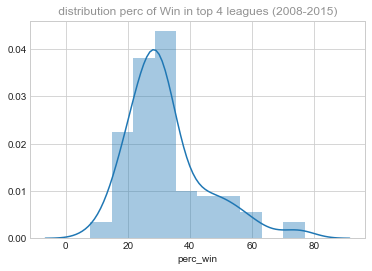

In [65]:
#http://mlwhiz.com/blog/2015/09/13/seaborn_visualizations/
sns.set_style("whitegrid")
g=sns.distplot(df_4l_all.groupby(['team'])['perc_win'].mean(), bins=10)
#Set the Title of the graph from here
g.axes.set_title(' distribution perc of Win in top 4 leagues (2008-2015) ', fontsize=12,alpha=0.5);

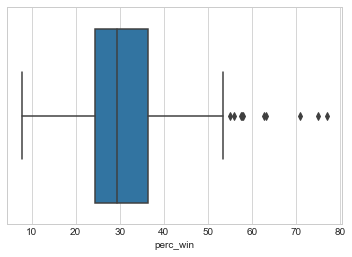

In [66]:
ax = sns.boxplot(x=df_4l_all.groupby(['team'])['perc_win'].mean())


> let's plot from each of the 4 leagues the top 10 teams sorted by Average winning percentage over 8 seasons 

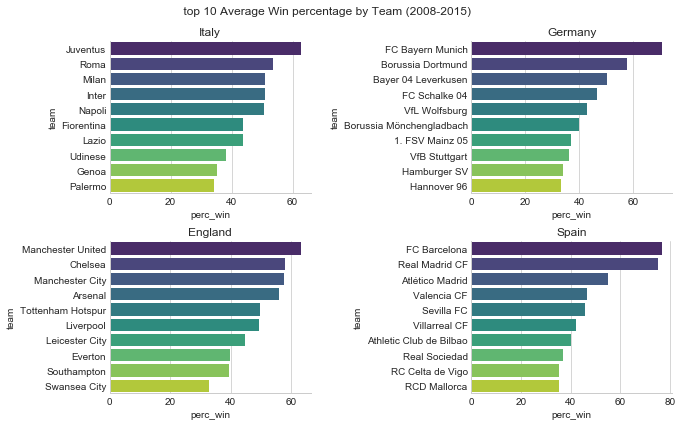

In [68]:
#let's plot the top 10 teams by Average winning percentage over 8 seasons from 4 leagues

#https://stackoverflow.com/questions/43085427/using-dataframe-plot-to-make-a-chart-with-subplots-how-to-use-ax-parameter

countries = ['Italy', 'Germany', 'England', 'Spain']

fig, axes = plt.subplots(2,2, figsize=(10, 6))
fig.suptitle(" top 10 Average Win percentage by Team (2008-2015)", fontsize=12)

for ax, country in zip(axes.flatten(), countries):
        df = df_4l_all[df_4l_all.country == country].groupby(['team']).mean().sort_values('perc_win', 
                                                                                        ascending = False).head(10)
        sns.barplot(x=df.perc_win, y=df.index, data=df, ax=ax, palette = 'viridis')
                                                                      
        ax.set_title('{0}'.format(country))       

sns.despine()
plt.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.9)


> Based on the above in order to specify the successful teams (Elite teams) and then
study their technical and tactical characteristics:<br>
> let's classify the teams between Elites and the remaining teams labeled as other <br>
> We can consider Europe's top 4 leagues Elites.The teams that have dominated their domestic leagues from 2008 to 2015 setting and have set the winning standard: <br>
> teams that have an Average of winning percentage > 90th percentile.


In [164]:
#Based Above in order to study the successfull teams (Elite teams) characteristics
#let's divide the teams between Elite and others
#We can consider Europe's top 4 leagues Elites 
#teams that have a  average of winning percentage > 90th percentile  

elite_level = df_4l_all.groupby(['team'])['perc_win'].mean().quantile(0.90)
 

avgwin_teams = df_4l_all.groupby(['team'])[['perc_win']].mean()
europe_elites = avgwin_teams [avgwin_teams.perc_win > elite_level]  



# let's divide teams based on their percentage of Winning and check some important
# characteristics goal scored, goal conceded and percentage of away winning

df_4l_all['level'] = np.where(df_4l_all.team.isin(europe_elites.index),
                             'elite', 'other')



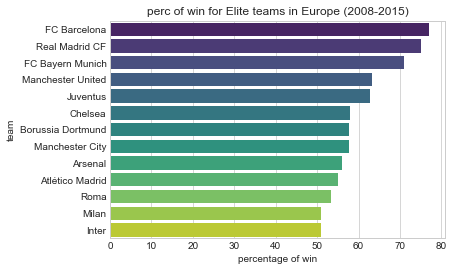

In [71]:
#getting sorted elites teams by percentage of win from 2008 to 2015
elites_in_order = europe_elites.sort_values(by='perc_win' ,ascending =False)
sns.barplot(x='perc_win', y=elites_in_order.index, data=elites_in_order, palette = 'viridis')
plt.title('perc of win for Elite teams in Europe (2008-2015)')
plt.xlabel ('percentage of win');


In [73]:
#let's Team details by Country
#Italy
df_italy = df_4l_all[df_4l_all.country == 'Italy']
#England
df_england = df_4l_all[ df_4l_all.country == 'England']
#Germany
df_germany = df_4l_all[ df_4l_all.country == 'Germany']
#Spain
df_spain = df_4l_all[ df_4l_all.country == 'Spain']

### Penalties scored
> Generally in Football there is a link between the number of Goals scored and the number of
 Goals conceded and success. But is there a relationship between success and the number of penalties scored? <br>

>Based on the below scatter plot and the correlation calculation, there is no obvious/strong relationship (correlation) between penalties scored and the percentage of win recorded by teams 

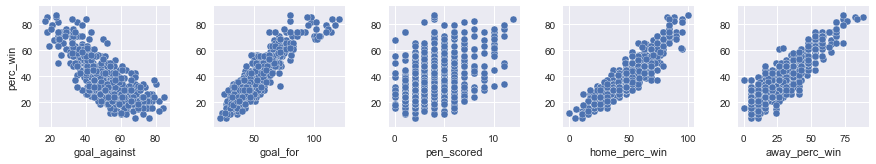

In [74]:
# generate scatter plots showing the relation between different parameters and the winning percentage.
#though for penalty scored average the correlation is not obvious
sns.set()
data = df_4l_all
p = sns.pairplot(data=data,
                  y_vars=['perc_win'],
                  x_vars=['goal_against', 'goal_for', 
                          'pen_scored', 'home_perc_win','away_perc_win'])





In [75]:
df_4l_all['perc_win'].corr(df_4l_all['pen_scored'])

0.36716908916484953

In [79]:
# grouping based on season and level
elite_other_goals = df_4l_all.groupby(['season', 'level'])['goal_for_game', 
                                                           'goal_against_game' ].mean()


elite_other_goals

goal_for_game  goal_against_game
season level                                  
2008   elite       1.921886           1.077518
       other       1.247273           1.416147
2009   elite       2.025959           1.047749
       other       1.232008           1.427649
2010   elite       1.929983           0.986425
       other       1.257395           1.446106
2011   elite       2.117430           0.969408
       other       1.225347           1.455954
2012   elite       2.117528           1.030483
       other       1.260967           1.478376
2013   elite       2.128483           0.909264
       other       1.279876           1.523720
2014   elite       1.957371           0.913075
       other       1.206836           1.415159
2015   elite       1.957609           0.900810
       other       1.234342           1.445701

In [80]:
# getting goal scored difference Elites vs rest of the teams
# getting goal conceded difference Elites vs rest of the teams

goal_diff = elite_other_goals.unstack()
goal_diff['goal_scored_diff'] = goal_diff['goal_for_game'].elite - goal_diff['goal_for_game'].other
goal_diff['goal_conceded_diff'] = abs(goal_diff['goal_against_game'].elite - goal_diff['goal_against_game'].other)



In [81]:
#grooping based on season and level
elite_other_win = df_4l_all.groupby(['season', 'level'])['home_perc_win', 
                                                           'away_perc_win' ].mean()



In [82]:
# getting Home win difference Elites vs rest of the teams
# getting Away win difference Elites vs rest of the teams
win_diff=elite_other_win.unstack()
win_diff['home_win_diff'] = win_diff['home_perc_win'].elite - win_diff['home_perc_win'].other
win_diff['away_win_diff'] = win_diff['away_perc_win'].elite - win_diff['away_perc_win'].other

win_diff

home_perc_win            away_perc_win            home_win_diff  \
level          elite      other         elite      other                 
season                                                                   
2008       67.349369  44.286735     48.082877  23.662777     23.062634   
2009       73.922362  42.924506     45.201238  21.743272     30.997857   
2010       70.016671  43.696118     46.153846  24.129555     26.320553   
2011       71.936440  41.372814     51.631341  22.833677     30.563626   
2012       70.373899  40.766849     55.394141  23.700881     29.607049   
2013       74.112884  41.943320     57.061205  25.463206     32.169564   
2014       68.301977  39.592231     48.892593  24.937154     28.709746   
2015       69.397476  40.038104     52.107645  25.429864     29.359371   

       away_win_diff  
level                 
season                
2008       24.420100  
2009       23.457966  
2010       22.024291  
2011       28.797663  
2012       31.693260  
2013       31.598000  
2014       23.955439  
2015       26.677780

> We known that Elite teams on Average score more goals than away teams and concede less.
> And that Elite teams have more Home Wins and Away Wins than the rest of the teams.
> But let's compare both metrics to see in which Elite teams Excel more compared to 
> the rest of the teams:
1. is it Goal scoring or Goal conceding?
2. is it Away Wins or Home Wins?<br>
>From the line chart below, it looks like Elite teams tend to have an Average of Goal scored  which is **HIGHER** than the Average Goal conceded difference when compared to the rest of the teams.<br>
> Overall Elite teams tend to have an Average of percentage of Home Win difference compared to the rest of teams __slightly higher__ than the Average of percentage of Away Win difference.



> line plots showing the trend of difference between the Average of Goal scored  and the difference in the Average of Goal conceded extended from 2008 to 2015  (Elite vs Rest of teams)


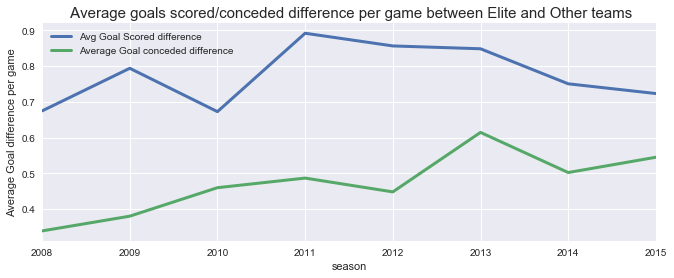

In [83]:
goal_diff.plot(x=goal_diff.index, y=['goal_scored_diff', 'goal_conceded_diff'], 
               figsize=(11, 4), linewidth=3, legend = False)

plt.title(' Average goals scored/conceded difference per game between Elite and Other teams', fontsize=15)
plt.ylabel('Average Goal difference per game');
plt.legend(['Avg Goal Scored difference', 'Average Goal conceded difference']);




> Average of difference Goals scored (Elite vs Other teams)

In [84]:
goal_diff['goal_scored_diff'].mean()

0.7765257242153526

> Average of difference of Goals conceded (Elite vs Other teams)

In [85]:
goal_diff['goal_conceded_diff'].mean()

0.47175986583494334

> line plots showing the trend of difference between the Average of Home Win and the difference in the Average of Away Win extended from 2008 to 2015  (Elite vs Rest of teams)

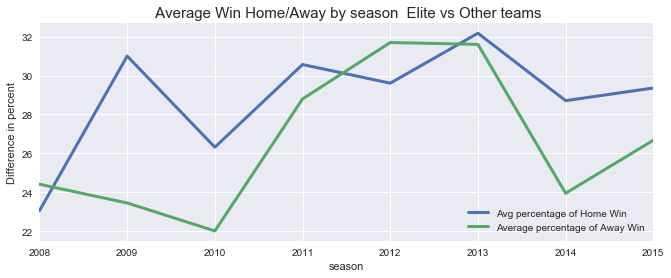

In [320]:

win_diff.plot(x=win_diff.index, y=['home_win_diff', 'away_win_diff'], 
               figsize=(11, 4), linewidth=3, legend = False)

plt.title(' Average Win Home/Away by season  Elite vs Other teams', fontsize=15)
plt.ylabel('Difference in percent');
plt.legend(['Avg percentage of Home Win', 'Average percentage of Away Win']);

Average Home win difference over 8 seasons

In [346]:
win_diff['home_win_diff'].mean()

28.848799978830932

Average Away win difference over 8 seasons

In [347]:
win_diff['away_win_diff'].mean()

26.578062567807148

In [88]:
#https://stackoverflow#questions/32484453/how-to-use-viridis-in-matplotlib-1-4

def show_goals_awin(dframe, country):
    '''Function that takes a DataFrame of matches Data
       and the country name and generated  barplots
       showing the average by level of:
       goal_for_game
       goal_against_game
       away_perc_win
       home_perc_win
       '''
    #https://seaborn.pydata.org/examples/color_palettes.html
    fig, (ax1, ax2, ax3 , ax4) = plt.subplots(4,1, figsize=(8, 8),sharex = True)
    fig.suptitle("league Elite teams vs Others ({0})".format(country), fontsize=14)
    sns.barplot(x='season', y='goal_for_game', hue='level' ,  data=dframe, ax=ax1, palette='viridis')
    ax1.legend(bbox_to_anchor=(1.05,1), loc=0, borderaxespad=0.)
    sns.barplot(x='season', y='goal_against_game', hue='level' , data=dframe, ax=ax2, palette='viridis' )
    ax2.legend(bbox_to_anchor=(1.05,1), loc=0, borderaxespad=0.)
    sns.barplot(x='season', y='away_perc_win', hue='level', data=dframe ,ax=ax3, palette= 'viridis')
    ax3.legend(bbox_to_anchor=(1.05,1), loc=0, borderaxespad=0.)
    sns.barplot(x='season', y='home_perc_win', hue='level', data=dframe ,ax=ax4, palette= 'viridis')
    ax4.legend(bbox_to_anchor=(1.05,1), loc=0, borderaxespad=0.)

> barplots by country League (league Elite vs rest of the teams)

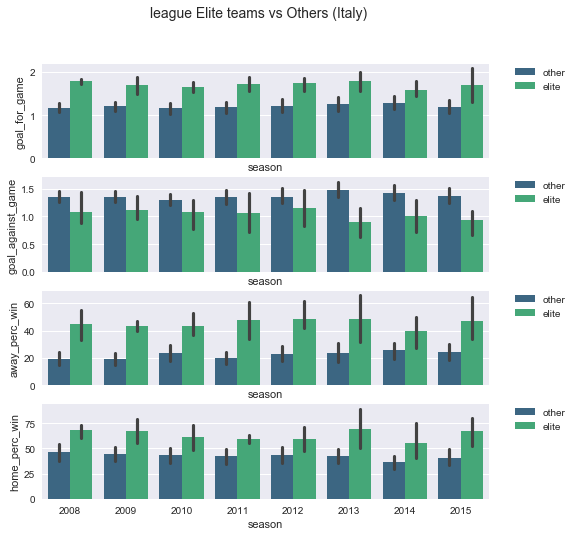

In [89]:
show_goals_awin(df_italy,'Italy')

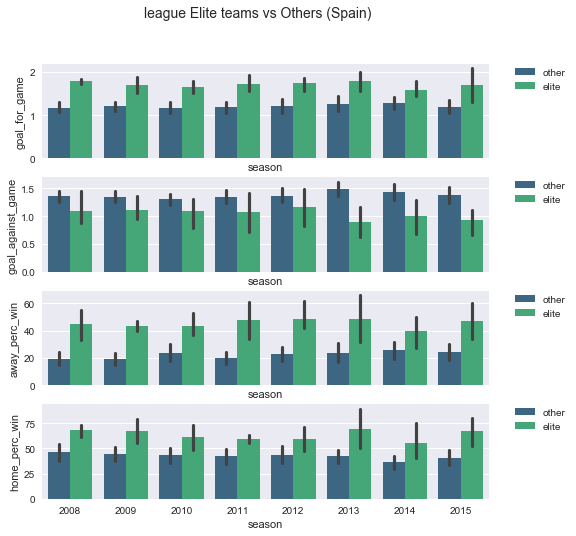

In [91]:
show_goals_awin(df_italy,'Spain')

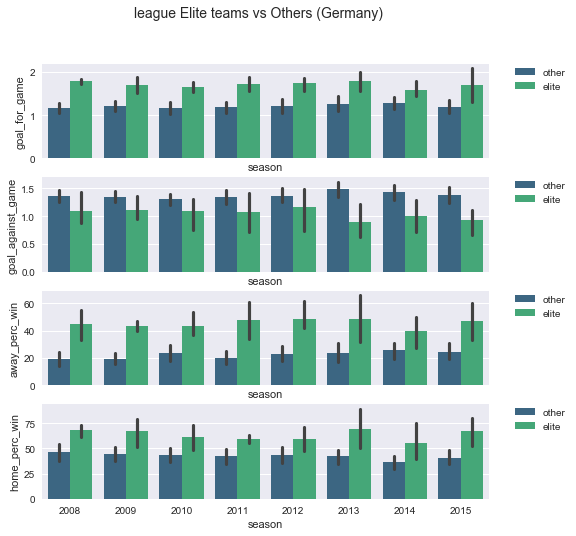

In [90]:
show_goals_awin(df_italy,'Germany')

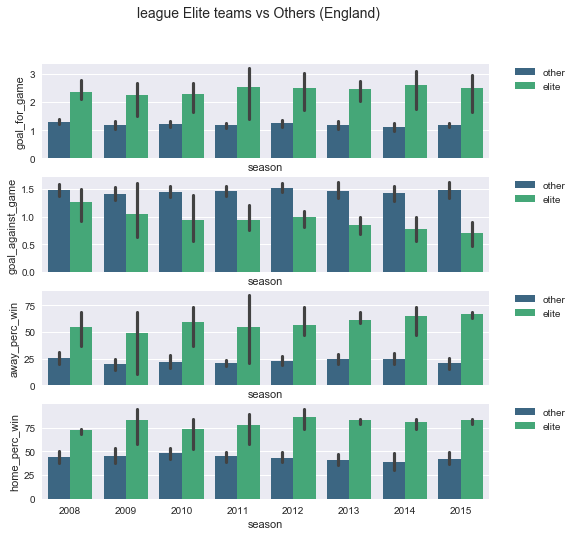

In [92]:
show_goals_awin(df_spain,'England')

>#### Questions:
>### In general do successful teams have more Ball possession? 
>### Do they have more shot on targets? 

> Since the Data Avaible for Possession and Shot on Target are more consistent
> for England Premier league, we will now focus on England for deeper exploration
> the techincal and tactical parameters that charcterise a winning team

In [95]:
#since the Data Avaible for Possession and Shot on Target are more complete
#for England Premier league, we will now focus on England for deeper exploration
#on the attributes that charcterise a winning team
df_england = team_stats_combined(england_hteam, england_ateam,'England')

df_england_f = df_england.copy()
df_england_f.drop('possession', axis=1, inplace=True)


In [96]:
#create level column for df_england_f dataframe
df_england_f['level'] = np.where(df_england_f.team.isin(europe_elites.index),
                                 'elite', 'other')


> Scatter plot showing postive correlation between: <br>
> Average possession percentage of Win <br>
> Average Shoton goals and percentage of Win <br> 
> ratio Goals to shots and percentage of Win

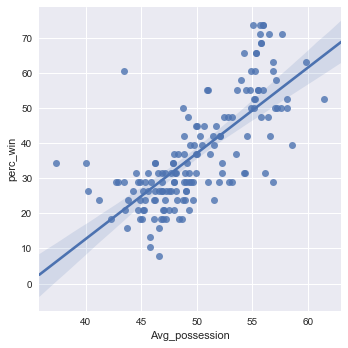

In [97]:
sns.lmplot(x="Avg_possession", y="perc_win", data=df_england_f);

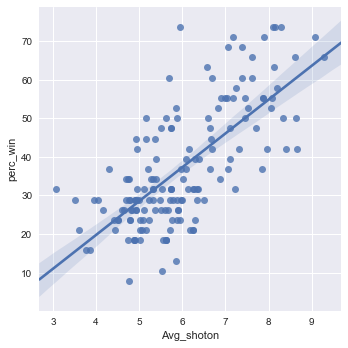

In [99]:
sns.lmplot(x="Avg_shoton", y="perc_win", data=df_england_f);

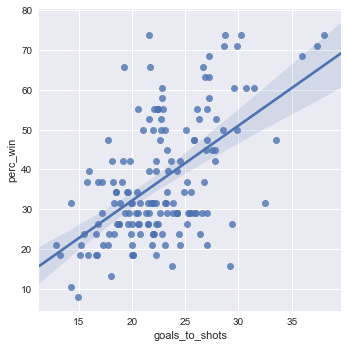

In [167]:
sns.lmplot(x="goals_to_shots", y="perc_win", data=df_england_f);

> Let's try to check in English Premier League the percentage of games teams that had more possession during the game did eventually win it. We will exclude the Matches that ended up with a Draw and Matches that ended with Equal possession percentage.
Counting games that ended with Win/loss

In [108]:
def poss_shoton_win(hgoal, agoal, homefeat, awayfeat):
    '''Function that takes 4 arguments
       home goal and away goal and other home or away
       technical/tactical characteristics (shoton/possession)
       of a team and returns:
       *1 in case the characteritc in question
       is dominant and the team won the game
       *0 in case the characteritc in question
       is dominant but the team lost the game
       *None in case of Draw (D is ignored)'''
    
    if (hgoal > agoal) and (homefeat > awayfeat):
        return 1
    elif (hgoal < agoal) and (homefeat < awayfeat):
        return 1
    elif hgoal == agoal:
        return None
    else:
        return 0

def avgwin_poss_shoton(grouped, poss_shoton):
    '''e.g returns average percentage of Games 
      won by team having more possession/shoton
      during the game.
      Sum of games won/(total games won + total games lost)
     '''
    
    wp = grouped[poss_shoton]
    return (wp.sum() / wp.count()) * 100 

In [169]:
epl_poss_win = epl_poss.copy()

#create a new column called 'poss_win' which is the average percentage of games won by teams
#in which they had more possession.
#use np.vectorize() to suply the poss_shoton_win with more than one argument
epl_poss_win['poss_win'] = np.vectorize(poss_shoton_win) (epl_poss_win['home_team_goal']
                                                          , epl_poss_win['away_team_goal'],
                                                            epl_poss_win['hteam_poss'], 
                                                          epl_poss_win['ateam_poss'])

epl_poss_win.head()

,match_id,country,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,ateam_poss,hteam_poss,poss_win
0,1729,England,2008,1,2008-08-17,Manchester United,Newcastle United,1,1,45.0,55.0,None
1,1730,England,2008,1,2008-08-16,Arsenal,West Bromwich Albion,1,0,34.0,66.0,1
2,1731,England,2008,1,2008-08-16,Sunderland,Liverpool,0,1,54.0,46.0,1
3,1732,England,2008,1,2008-08-16,West Ham United,Wigan Athletic,2,1,48.0,52.0,1
4,1733,England,2008,1,2008-08-17,Aston Villa,Manchester City,4,2,48.0,52.0,1


>In the premier league teams with more possessions win in Average 60% of the Games.

In [116]:
##calling avgwin_poss_shoton function
moreposs_win = epl_poss_win.groupby(['season']).apply(avgwin_poss_shoton, 'poss_win')

moreposs_win.mean()

60.623014530133545

> Now let's try a similar approach to check Average percentage of Games Won by teams who
had more shots on Goal

In [126]:
epl_shoton_win = epl_shoton.copy()

#create a new column called 'shoton_win' which is the average percentage of games won by teams
#in which they had more Shoton target.
#use np.vectorize() to suply the poss_shoton_win with more than one argument

epl_shoton_win['shoton_win'] = np.vectorize(poss_shoton_win) (epl_shoton_win['home_team_goal'], epl_shoton_win['away_team_goal'],
                                                    epl_shoton_win['hteam_shoton'], epl_shoton_win['ateam_shoton'])
epl_shoton_win.head()

,match_id,country,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,ateam_shoton,club_id_x,club_id_y,hteam_shoton,shoton_win
0,1729,England,2008,1,2008-08-17,Manchester United,Newcastle United,1,1,1,10261,10260,11,None
1,1730,England,2008,1,2008-08-16,Arsenal,West Bromwich Albion,1,0,2,8659,9825,12,1
2,1731,England,2008,1,2008-08-16,Sunderland,Liverpool,0,1,11,8650,8472,4,1
3,1732,England,2008,1,2008-08-16,West Ham United,Wigan Athletic,2,1,7,8528,8654,5,0
4,1733,England,2008,1,2008-08-17,Aston Villa,Manchester City,4,2,9,8456,10252,5,0


> In the English Premier league Team with more Shoton Target (including blocked/deflected shots) win 52% of the Game

In [127]:
#calling avgwin_poss_shoton function
moreshoton_win= epl_shoton_win.groupby(['season']).apply(avgwin_poss_shoton, 'shoton_win')
moreshoton_win.mean()

52.207402766062096

> Bar plot Percentage of Games won by Teams with more possession
> Bar plot Percentage of Games won by Teams with more shoton target

In [132]:
#preparing DataFrame for plotting
df_moreposs_win = pd.DataFrame({'season':moreposs_win.index, 'poss_winperc':moreposs_win.values})
df_moreshoton_win = pd.DataFrame({'season':moreshoton_win.index, 'shoton_winperc':moreshoton_win.values})


In [134]:
df_moreshoton_win

,season,shoton_winperc
0,2008,54.063604
1,2009,52.464789
2,2010,49.814126
3,2011,51.567944
4,2012,56.985294
5,2013,51.655629
6,2014,49.825784
7,2015,51.282051


In [133]:
df_moreposs_win

,poss_winperc,season
0,67.844523,2008
1,67.605634,2009
2,61.710037,2010
3,65.853659,2011
4,62.500000,2012
5,55.298013,2013
6,54.355401,2014
7,49.816850,2015


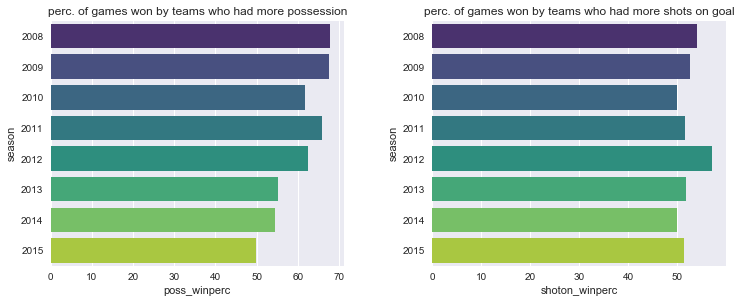

In [135]:
# percentage of game won by team having more possession in the game
#not counting matches that ended with a Draw

fig, axes = plt.subplots(1,2, figsize=(12, 4))
sns.barplot(y="season", x="poss_winperc",  data=df_moreposs_win, orient ='h', palette = 'viridis', ax=axes[0])
axes[0].set_title('perc. of games won by teams who had more possession')
sns.barplot(y="season", x="shoton_winperc",  data=df_moreshoton_win, orient ='h', palette = 'viridis', ax=axes[1])
axes[1].set_title('perc. of games won by teams who had more shots on goal')
plt.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.3, top=1)

> Finally Bar charts showing (England Elites vs other teams):<br>
> Avg possession <br>
> Avg Shoton <br>
> The ratio of Goals to shots <br> 

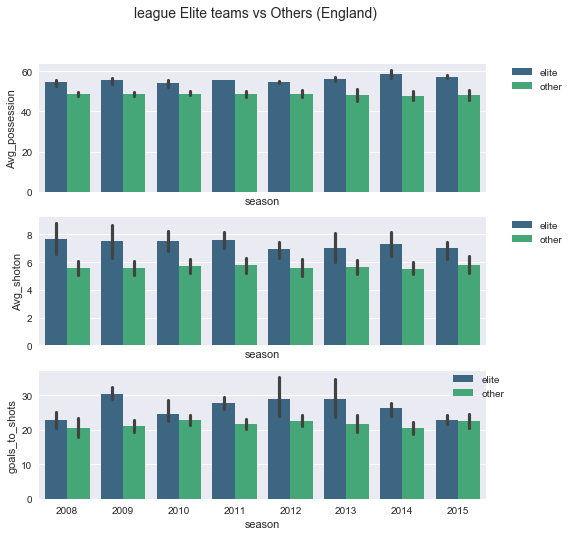

In [137]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 8),sharex = True)
fig.suptitle("league Elite teams vs Others ({0})".format('England'), fontsize=14)
sns.barplot(x='season', y='Avg_possession', hue='level' , data=df_england_f, ax=ax1, palette='viridis')
ax1.legend(bbox_to_anchor=(1.05,1), loc=0, borderaxespad=0.)
sns.barplot(x='season', y='Avg_shoton', hue='level' , data=df_england_f, ax=ax2, palette='viridis' )
ax2.legend(bbox_to_anchor=(1.05,1), loc=0, borderaxespad=0.)
sns.barplot(x='season', y='goals_to_shots', hue='level' , data=df_england_f, ax=ax3, palette='viridis' )
ax3.legend(bbox_to_anchor=(1.05,1), loc=0, borderaxespad=0.);

>Average of Ratio goals to shots (Elite vs Others)

In [166]:
df_england_f.groupby('level').mean()['goals_to_shots']

level
elite    26.567327
other    21.670881
Name: goals_to_shots, dtype: float64

> let's explore which EPL Team has improved the most between 2012 and 2014

In [139]:
#create 2 DFs one for season 2012 and other for season 2014
#from the original England Data Set.

df_england_f_12 = df_england_f[df_england_f.season == '2012']
df_england_f_14 = df_england_f[df_england_f.season == '2014']

In [143]:
#setting team as index
win_perc_12 = df_england_f_12[['team','perc_win']].set_index('team')
#Renaming perc_win to perc_win12 to differentiate later with perc_win of 2015
win_perc_12.rename(columns={'perc_win': 'perc_win12'}, inplace = True)

win_perc_12.head()

,perc_win12
team,
Arsenal,55.263158
Aston Villa,26.315789
Chelsea,57.894737
Everton,42.105263
Fulham,28.947368


In [144]:
#setting team as index
win_perc_14 = df_england_f_14[['team','perc_win']].set_index('team')
win_perc_12.head()

,perc_win12
team,
Arsenal,55.263158
Aston Villa,26.315789
Chelsea,57.894737
Everton,42.105263
Fulham,28.947368


In [145]:
#win diff is concatenation of win_perc_12 and win_perc_14
win_diff = pd.concat([win_perc_12,win_perc_14 ], axis=1)
win_diff.dropna(inplace = True)

In [146]:
#create a new column to store the difference in win percentage
win_diff['improv'] = win_diff.perc_win - win_diff.perc_win12

In [147]:
# store in only_improved teams who have improved based on average win percentage
only_improved = win_diff[win_diff.improv > 0].sort_values('improv', ascending = False)

> The team who improved the most is 'Southampton'

In [148]:
 only_improved['improv'].argmax()

'Southampton'

>let's plot teams with increase of Win percentage from 2012 to 2014

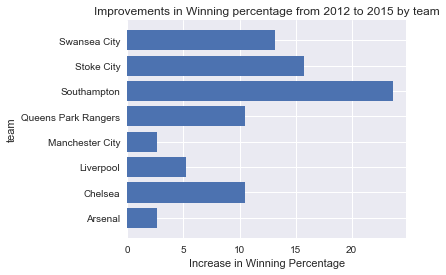

In [150]:
plt.subplots(figsize=(5, 4))
plt.barh(only_improved.index, only_improved['improv'])
plt.title('Improvements in Winning percentage from 2012 to 2015 by team')
plt.xlabel('Increase in Winning Percentage')
plt.ylabel('team');

> Looking at different parameters between 2012 and 2014 we notice that Avg possession increased from 48.7% to 53/%, goal_to_shots also increased from 22% to 26%.
> But the most important parametr to look for is the decrease in the number of goal conceded 
it dropped from 60 goals in 2012 to 33 in 2014.

In [151]:
#store Southampton parameters on 2012 and 2014
Southampton_12_14 = df_england_f[(df_england_f.season.isin(['2012', '2014'])) & (df_england_f.team == 'Southampton')]
Southampton_12_14

,team,season,away_perc_win,goal_against,goal_for,home_perc_win,played,shoton,win,perc_win,goal_for_game,goal_against_game,Avg_possession,Avg_shoton,goals_to_shots,level
104,Southampton,2012,15.789474,60.0,49.0,31.578947,38.0,223.0,9.0,23.684211,1.289474,1.578947,48.763158,5.868421,21.973094,other
106,Southampton,2014,36.842105,33.0,54.0,57.894737,38.0,209.0,18.0,47.368421,1.421053,0.868421,53.210526,5.500000,25.837321,other


<a id='conclusions'></a>
## Conclusions

> First of based on the average Win percentage, we tried to classify teams from the top 4 leagues 
in Europe (England, Spain, Germany and Italy) between Elites and the rest of the teams. <br>
> Elite teams (with Average Win percentage above 50% from 2009 to 2015) are considered the successful teams that dominate their domestic leagues.<br>
> Following that we found that Elite teams tend to Score in Average more goals with a difference of 0.77 goal per game compared to the rest of the teams, while this difference decreases to 0.47 in case of Goal conceded.<br> 
__Though this difference depends on more than one variable and more exploration and statistical analysis is needed__ to confirm it, but maybe we can attribute that to the offensive weapons that Elite teams possess.<br> 
>While defensively smaller teams with less resources can still be tactically well organized to reduce the chances of conceding more goals and thus reducing the margin of difference in Goals conceded compared to Goals scored.

>Now looking at percentage of possession, we found in the English Premier League that 62% of games are won by teams with more possession, also Elite teams tend to have more possession in Average compared to the rest of the teams. __But we cannot rely on possession solely as a indicator for Winning games as other factors comes into place to influence the possession itself__. <br>
>Also we tried to explore the shoton target, and found in the EPL teams with more Shoton target wins
in Average around 52% of the games. And Elite teams had more Average shoton Targets when compared to the rest of the teams, but again this is one of the key performance measures to look when studying sucessful vs unsuccessful teams.<br> 
> We tried to check the ratio of goals per shots and found that Elite teams in Average tend to have higher ratio of Goals per shots 26.5 % vs 21.6% for the rest of the teams.

> Finally the info that we obtained here might vary and be invalid in other leagues or competitions.


### References:

https://stackoverflow.com/questions/19914937/applying-function-with-multiple-arguments-to-create-a-new-pandas-column

https://alysivji.github.io/pl-analysis-part1-finding-longest-consecutive-position-streak.html

https://chrisalbon.com/python/pandas_create_column_using_conditional.html

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html

https://stackoverflow.com/questions/38082602/plotting-multiple-different-plots-in-one-figure-using-seaborn

https://seaborn.pydata.org/

https://matplotlib.org/

https://tomaugspurger.github.io/modern-5-tidy.html

https://exceptionshub.com/applying-function-with-multiple-arguments-to-create-a-new-pandas-column.html

https://www.kaggle.com/dimarudov/data-analysis-using-sql

https://www.kaggle.com/hugomathien/soccer/discussion/44871

https://www.kaggle.com/timon88/extracting-goal-times/comments

https://www.kaggle.com/jiezi2004/the-beautiful-game-1-data-preparation

https://www.kaggle.com/jiezi2004/soccer